In [10]:
import sys 
sys.path.append("OPM_lab")

import numpy as np
import matplotlib.pyplot as plt

from OPM_lab.sensor_locations import HelmetTemplate, FL_alpha1_helmet

In [11]:
def make_sensor_reference_layout(template:HelmetTemplate, channel_names, Z):
    """
    Create a sensor reference layout based on a helmet template and specified channels.

    Args:
        template (HelmetTemplate): The helmet template containing sensor information.
        channel_names (list of str): Names of the locations actually used for the sensors.
        Z (list of numeric): The z measurements of the channels used.

    Returns:
        OPMSensorLayout: The layout of the OPM sensors.
    """
    assert len(channel_names) == len(Z)

    # get indices of the channels used in the helmet template
    idx = [i for i, template_sens in enumerate(template.label) if template_sens in channel_names]
    template_pos = template.chan_pos[idx]
    template_ori = template.chan_ori[idx]

    print(template_pos)
    print(template_ori)

    # move the template_pos z in template ori to get the OPM pos

    # return OPMSensorLayout(OPM_ori, OPM_pos, channel_names)


make_sensor_reference_layout(FL_alpha1_helmet, channel_names= ["FL3", "FL10", "FL16"], Z = [0.03, 0.05, 0.01])


[[-0.03950802  0.12987231  0.00702394]
 [-0.06269032  0.1108322  -0.00455   ]
 [-0.08264246  0.08189714 -0.01993   ]]
[[-0.51169002  0.85434997  0.09093   ]
 [-0.74603999  0.66589999  0.        ]
 [-0.89486998  0.44633001  0.        ]]


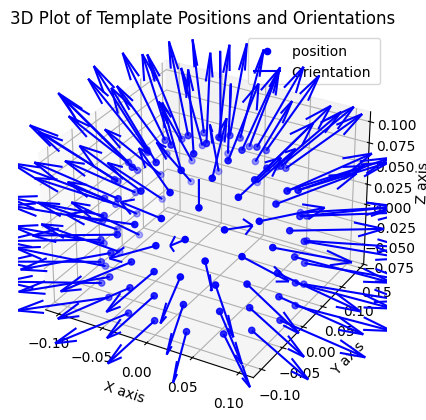

In [12]:


def plot_pos_ori(pos, ori, ax, label = "", c = "b"):

    # Plot positions
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], color=c, label=f'position {label}')

    # Plot orientations as arrows
    for i in range(len(pos)):
        x, y, z = pos[i]
        u, v, w = ori[i]
        
        ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True, color=c, label=f'Orientation {label}' if i == 0 else "")
        # Simple representation of orientation using arrows (may need adjustments based on actual orientation representation)
        #ax.quiver(x, y, z, np.cos(yaw), np.sin(yaw), 0, length=0.02, color=c, label=f'Orientation {label}' if i == 0 else "")


%matplotlib inline 
idx = [2, 3, 4]
template_pos_before = FL_alpha1_helmet.chan_pos
template_ori_before = FL_alpha1_helmet.chan_ori

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


plot_pos_ori(template_pos_before, template_ori_before, ax)

# ADD PLOTTING AFTER!!!

# Labels and legend
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

plt.title('3D Plot of Template Positions and Orientations')
plt.show()

In [13]:
import mne
from mne.datasets import sample

data_path = sample.data_path()
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_filt-0-40_raw.fif"

raw = mne.io.read_raw_fif(raw_fname)
raw.crop(0, 60).load_data()  # just use a fraction of data for speed here
raw.pick(["meg"])

Opening raw data file /Users/au661930/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 9009  =      0.000 ...    59.999 secs...


<Raw | sample_audvis_filt-0-40_raw.fif, 306 x 9010 (60.0 s), ~24.2 MB, data loaded>

# WORKING ON GETTING DIG POINTS INTO MNE OBJECT

In [15]:

import pandas as pd
points = pd.read_csv("/Users/au661930/Library/CloudStorage/OneDrive-Aarhusuniversitet/Dokumenter/project placement/OPM_lab/output/test1_digitisation.csv")
points["label"].unique()

array(['head', 'lpa', 'rpa', 'nasion', 'FL3', 'FL10', 'FL16', 'FL62',
       'fake', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'B1', 'B2',
       'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9'], dtype=object)

In [16]:
raw.pick(["MEG 0111", "MEG 0121", "MEG 0131", "MEG 0141"])

mne.rename_channels(raw.info, {"MEG 0111" : "FL3", 
                               "MEG 0121" : "FL10", 
                               "MEG 0131" : "FL16", 
                               "MEG 0141" : "FL62"})

In [20]:
from OPM_lab.sensor_locations import FL_alpha1_helmet

def make_dig_points_csv(df, mne_object, fieldline_template = FL_alpha1_helmet):

    fiducials = {}

    for label in ["nasion", "lpa", "rpa"]:
        fid = df[df["label"]==label].loc[:, ["x", "y", "z"]]
        fiducials[label] = np.array(fid).squeeze() / 100 # converting to meters!

    head_points = df[df["label"]=="head"].loc[:, ["x", "y", "z"]] / 100# 1000

    channel_pos_OPM = {}

    for ch_type in ["OPM"]:
        channels = df[df["sensor_type"]==ch_type]
        coordinates = np.array(channels.loc[:, ["x", "y", "z"]]).squeeze()
        labels = channels["label"]

        for coor, label in zip(coordinates, labels):
            coor = coor / 100
            
            idx = None
            
            # find the channel with the label in the info of the mne object
            for idx_tmp, ch in enumerate(mne_object.info["chs"]):

                mne_ch_name = ch["ch_name"]
                
                if mne_ch_name == label:
                    idx = idx_tmp
                    break
            
            # update the location of that channel
            print(f"{mne_object.info['chs'][idx]['loc']}, before")
            mne_object.info['chs'][idx]['loc'][:3] = coor

            print(f"{mne_object.info['chs'][idx]['loc']}, after")

            
            # change sensor orientations
            channel_orientation = FL_alpha1_helmet.get_chs_ori([label])
            print(f"CHANNEL_ORI : {channel_orientation}") 
            # PROBLEM IS THAT IT IS ONLY AN ARRAY OF SHAPE (3,) BUT MNE WANTS 9 NUMBERS
            #rot_coils = np.array([location[3:6], location[6:9], location[9:12]])
        
            #location[3:12] = rot_coils.flatten() # check if this is correct

            #print(mne_object.info["chs"][idx]["loc"])

    
    #dig_montage = mne.channels.make_dig_montage(ch_pos=channel_pos, nasion=fiducials["nasion"], lpa=fiducials["lpa"], rpa=fiducials["rpa"], hsp=head_points, coord_frame='head')
    #print(dig_montage)
    #mne_object.info.set_montage(dig_montage)

    #return dig_montage

make_dig_points_csv(points, raw) 

[-0.00858315 -0.03868327  0.01340499 -0.0127      0.0057     -0.99990302
 -0.186801   -0.98240298 -0.0033     -0.98232698  0.18674099  0.013541  ], before
[-0.00858315 -0.03868327  0.01340499 -0.0127      0.0057     -0.99990302
 -0.186801   -0.98240298 -0.0033     -0.98232698  0.18674099  0.013541  ], after
CHANNEL_ORI : [array([-0.51169002,  0.85434997,  0.09093   ])]
[-0.00698369 -0.05961791  0.02741866  0.0136      0.0011     -0.99990201
 -0.28200099 -0.95940202 -0.0049     -0.95931298  0.28203899 -0.012738  ], before
[-0.00698369 -0.05961791  0.02741866  0.0136      0.0011     -0.99990201
 -0.28200099 -0.95940202 -0.0049     -0.95931298  0.28203899 -0.012738  ], after
CHANNEL_ORI : [array([-0.74603999,  0.66589999,  0.        ])]
[-0.00297389 -0.07052033  0.0575644   0.0026      0.0023     -0.999955
 -0.095196   -0.99545598 -0.0025     -0.995417    0.095198   -0.002369  ], before
[-0.00297389 -0.07052033  0.0575644   0.0026      0.0023     -0.999955
 -0.095196   -0.99545598 -0.0025